# **Seleccion de Modelo**

📚 **Import libraries**

In [1]:
# Librerías para este notebook

# Librerías básicas y del sistema
from pathlib import Path
import warnings
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento de datos
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Modelo y transformaciones de datos
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin

# División de datos y validación
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    StratifiedKFold,
    ShuffleSplit,
    learning_curve,
)

# Algoritmos de clasificación
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Métricas de evaluación
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    roc_auc_score,
)

# Configuración
warnings.filterwarnings("ignore")

**Descripción de este notebook**

En este nuevo paso del proyecto de ciencia de datos buscaremos un modelo con la 
capacidad de predecir de una mejor manera el churn para nuestro data set, este modelo debe lograr por lo menos un mejor desempeño que nuestra aproximación con el modelo heuristico.

💾 **Cargamos los datos**

In [2]:
# configuración para que solo se muestren 2 decimales
pd.set_option("display.float_format", "{:.2f}".format)

BASE_DIR = Path("/home/lof/Projects/Telco-Customer-Churn")
DATA_DIR = BASE_DIR / "data" / "interim"
churn_df = pd.read_parquet(DATA_DIR / "churn_type_fixed.parquet", engine="pyarrow")
churn_df.head()

,MonthlyCharges,StreamingMovies,Partner,PhoneService,InternetService,StreamingTV,OnlineSecurity,MultipleLines,Dependents,DeviceProtection,SeniorCitizen,TotalCharges,TechSupport,gender,PaperlessBilling,tenure,Churn,OnlineBackup,PaymentMethod,Contract
0,99.45,Yes,0.00,1.00,Fiber optic,No,Yes,Yes,0.00,Yes,0.00,5623.70,No,Female,1.00,59.00,0.00,Yes,Bank transfer (automatic),Month-to-month
1,80.40,Yes,1.00,1.00,Fiber optic,No,No,No,0.00,No,0.00,2937.65,No,Female,0.00,36.00,0.00,No,Electronic check,Month-to-month
2,98.70,Yes,1.00,1.00,Fiber optic,Yes,No,Yes,0.00,Yes,1.00,5812.60,No,Male,1.00,58.00,1.00,No,Electronic check,Month-to-month
3,93.15,Yes,1.00,1.00,Fiber optic,Yes,No,No,0.00,Yes,1.00,2231.05,No,Male,1.00,24.00,1.00,No,Electronic check,Month-to-month
4,50.05,Yes,0.00,0.00,DSL,Yes,No,No phone service,0.00,Yes,1.00,2743.45,No,Male,1.00,55.00,0.00,No,Bank transfer (automatic),One year


👷 **Data preparation**

In [3]:
# Clasificamos correctamente el tipo de dato de las variables
cols_boolean = [
    "SeniorCitizen",
    "Partner",
    "Dependents",
    "PhoneService",
    "PaperlessBilling",
    "Churn",
]
churn_df[cols_boolean] = churn_df[cols_boolean].astype("category")
cols_categoric = [
    "StreamingMovies",
    "InternetService",
    "StreamingTV",
    "OnlineSecurity",
    "MultipleLines",
    "DeviceProtection",
    "TechSupport",
    "gender ",
    "OnlineBackup",
    "PaymentMethod",
    "Contract",
]
churn_df[cols_categoric] = churn_df[cols_categoric].astype("category")

churn_df.drop_duplicates(inplace=True, keep="first")


In [4]:
selected_features = [
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "Contract",
    "SeniorCitizen",
    "PaymentMethod",
    "Churn",
    "tenure",
    "MonthlyCharges",
]

churn_features = churn_df[selected_features]

churn_features.info()


<class 'pandas.core.frame.DataFrame'>
Index: 6917 entries, 0 to 11361
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   PhoneService     6841 non-null   category
 1   MultipleLines    6825 non-null   category
 2   InternetService  6804 non-null   category
 3   Contract         6833 non-null   category
 4   SeniorCitizen    6891 non-null   category
 5   PaymentMethod    6832 non-null   category
 6   Churn            6866 non-null   category
 7   tenure           6856 non-null   float64 
 8   MonthlyCharges   6841 non-null   float64 
dtypes: category(7), float64(2)
memory usage: 210.4 KB


In [5]:
churn_features.isna().sum()

PhoneService        76
MultipleLines       92
InternetService    113
Contract            84
SeniorCitizen       26
PaymentMethod       85
Churn               51
tenure              61
MonthlyCharges      76
dtype: int64

In [6]:
print(len(churn_features.drop_duplicates()))
churn_features = churn_features.drop_duplicates()

6758


La variable target **"Churn"** ya está codificada en 1 y 0

In [7]:
cols_numeric = ["tenure", "MonthlyCharges"]
cols_categoric = [
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "Contract",
    "SeniorCitizen",
    "PaymentMethod",
    # "Churn",
]

In [8]:
# Definir constantes para los valores límites
MAX_MONTHLY_CHARGE = 500
MIN_MONTHLY_CHARGE = 0


def replace_out_of_range_values(X: pd.DataFrame) -> pd.DataFrame:
    """
    Reemplaza valores fuera de rango en las columnas 'MonthlyCharges' y 'TotalCharges' con np.nan.
    """
    assert isinstance(X, pd.DataFrame)
    mask = ~(
        (X["MonthlyCharges"] > MIN_MONTHLY_CHARGE)
        & (X["MonthlyCharges"] < MAX_MONTHLY_CHARGE)
    )
    X.loc[mask, "MonthlyCharges"] = np.nan
    return X


def replace_invalid_values(X: pd.DataFrame) -> pd.DataFrame:
    """
    Reemplaza valores incorrectos en columnas específicas con np.nan.
    También convierte columnas específicas al tipo 'category'.
    """
    assert isinstance(X, pd.DataFrame)

    # Reemplazar valores inválidos
    invalid_values = {
        "StreamingTV": "5412335",
        "StreamingMovies": "1523434",
        "MultipleLines": "1244132",
        "DeviceProtection": "1243524",
    }
    X = X.astype(str).replace(invalid_values, np.nan)

    # Definir columnas a convertir a tipo 'category'
    cols_boolean = [
        "SeniorCitizen",
        "Partner",
        "Dependents",
        "PhoneService",
        "PaperlessBilling",
        "Churn",
    ]
    cols_categoric = [
        "StreamingMovies",
        "InternetService",
        "StreamingTV",
        "OnlineSecurity",
        "MultipleLines",
        "DeviceProtection",
        "TechSupport",
        "gender",
        "OnlineBackup",
        "PaymentMethod",
        "Contract",
    ]

    # Convertir a tipo 'category' solo si existen en el DataFrame
    existing_cols_boolean = [col for col in cols_boolean if col in X.columns]
    existing_cols_categoric = [col for col in cols_categoric if col in X.columns]

    X[existing_cols_boolean] = X[existing_cols_boolean].astype("category")
    X[existing_cols_categoric] = X[existing_cols_categoric].astype("category")

    return X


In [9]:
from sklearn.impute import KNNImputer  # type: ignore
from sklearn.pipeline import FunctionTransformer  # type: ignore
from sklearn.preprocessing import OneHotEncoder  # type: ignore

# Para esta heuristica no se necesita escalar las variables numericas
# Tampoco se neecesita codificar las variables categoricas con el onehot encoder
# Se crean dos pipelines, uno para las variables numericas y otro para las categoricas
numeric_pipe = Pipeline(
    steps=[
        (
            "outlier_removal",
            FunctionTransformer(replace_out_of_range_values, validate=False),
        ),
        ("imputer", KNNImputer(n_neighbors=5)),
    ]
)

categorical_pipe = Pipeline(
    steps=[
        (
            "clean_categories",
            FunctionTransformer(replace_invalid_values, validate=False),
        ),
        ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "onehot",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
        ),  # ⬅️ Aquí
    ]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("numericas", numeric_pipe, cols_numeric),
        ("categoricas nominales", categorical_pipe, cols_categoric),
    ]
)


In [10]:
preprocessor

ColumnTransformer(transformers=[('numericas',
                                 Pipeline(steps=[('outlier_removal',
                                                  FunctionTransformer(func=<function replace_out_of_range_values at 0x7fdd19eba3e0>)),
                                                 ('imputer', KNNImputer())]),
                                 ['tenure', 'MonthlyCharges']),
                                ('categoricas nominales',
                                 Pipeline(steps=[('clean_categories',
                                                  FunctionTransformer(func=<function replace_invalid_values at 0x7fdd19eba700>)),
                                                 ('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['PhoneService', 'MultipleLines',
                                  'InternetService', 'Contract',
                                  'SeniorCitizen', 'PaymentMethod'])])

In [11]:
churn_features = churn_features.dropna(subset=["Churn"])
churn_features["Churn"] = churn_features["Churn"].astype(int)
X_features = churn_features.drop(columns=["Churn"])
Y_target = churn_features["Churn"]

# 80% train, 20% test
x_train, x_test, y_train, y_test = train_test_split(
    X_features, Y_target, test_size=0.2, stratify=Y_target
)

In [12]:
def summarize_classification(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred, normalize=True)
    prec = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)

    return {"accuracy": acc, "precision": prec, "recall": recall, "f1": f1, "roc": roc}

In [13]:
def build_model(
    classifier_fn,
    preprocessor: ColumnTransformer,
    data_params: dict,
    test_frac: float = 0.2,
) -> dict:
    """
    Function to train a classification model

    Args:
        classifier_fn: classification function
        preprocessor (ColumnTransformer): preprocessor pipeline object
        data_params (dict): dictionary containing 'name_of_y_col',
                            'names_of_x_cols', and 'dataset'
        test_frac (float): fraction of data for the test, default 0.2

    Returns:
        dict: dictionary with the model performance metrics on train and test
    """

    # Extract data parameters
    name_of_y_col = data_params["name_of_y_col"]
    names_of_x_cols = data_params["names_of_x_cols"]
    dataset = data_params["dataset"]

    # Separate the feature columns and the target column
    X = dataset[names_of_x_cols]
    Y = dataset[name_of_y_col]

    # Split the data into train and test
    x_train, x_test, y_train, y_test = train_test_split(
        X, Y, test_size=test_frac, random_state=1234, stratify=Y
    )
    # Create the pipeline with preprocessing and the classification model
    classifier_pipe = Pipeline(
        steps=[("preprocessor", preprocessor), ("classifier", classifier_fn)]
    )

    # Train the classifier pipeline
    model = classifier_pipe.fit(x_train, y_train)

    # Predict the test data
    y_pred = model.predict(x_test)

    # Predict the train data
    y_pred_train = model.predict(x_train)

    # Calculate the performance metrics
    train_summary = summarize_classification(y_train, y_pred_train)
    test_summary = summarize_classification(y_test, y_pred)

    # Añado el modelo y otros datos útiles para análisis posterior
    return {"model": model, "train": train_summary, "test": test_summary}

In [14]:
FEATURES = list(x_train.columns)
FEATURES
FEATURES = [col for col in x_train.columns if col != "Churn"]

In [15]:
result_dict = {}
models = {
    "logistic_regression": LogisticRegression(solver="liblinear", random_state=42),
    "decision_tree": DecisionTreeClassifier(random_state=42),
    "random_forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "gradient_boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "svm": SVC(probability=True, random_state=42),
    "knn": KNeighborsClassifier(n_neighbors=5),
}

data_params = {
    "name_of_y_col": "Churn",
    "names_of_x_cols": FEATURES,
    "dataset": churn_features,
}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    result_dict[model_name] = build_model(model, preprocessor, data_params)
    print(f"{model_name} completed.\n")


Training logistic_regression...


logistic_regression completed.

Training decision_tree...
decision_tree completed.

Training random_forest...
random_forest completed.

Training gradient_boosting...
gradient_boosting completed.

Training svm...
svm completed.

Training knn...
knn completed.



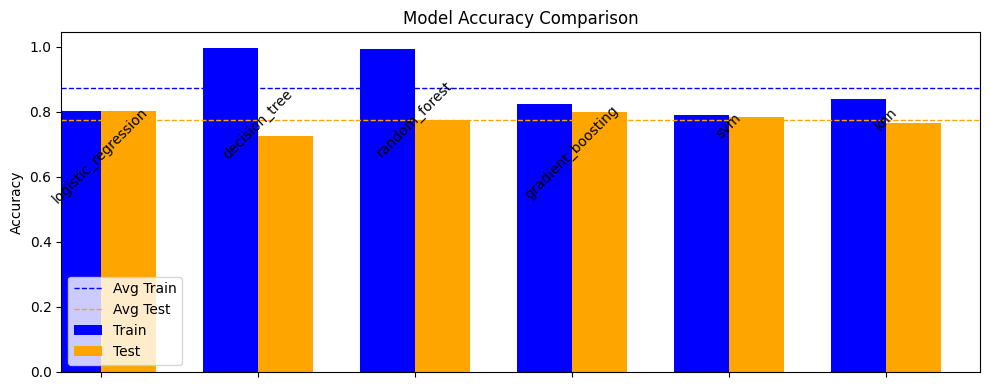

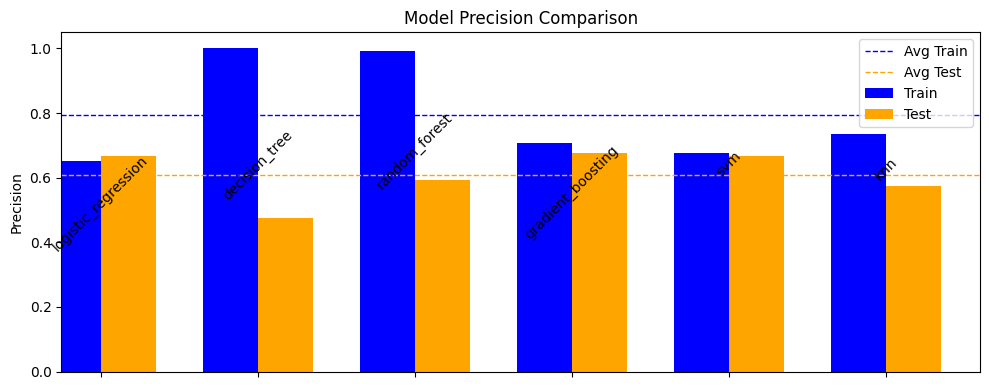

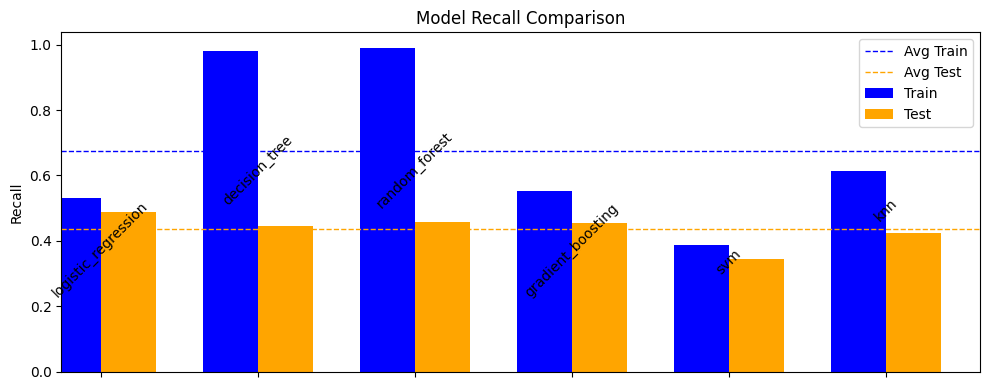

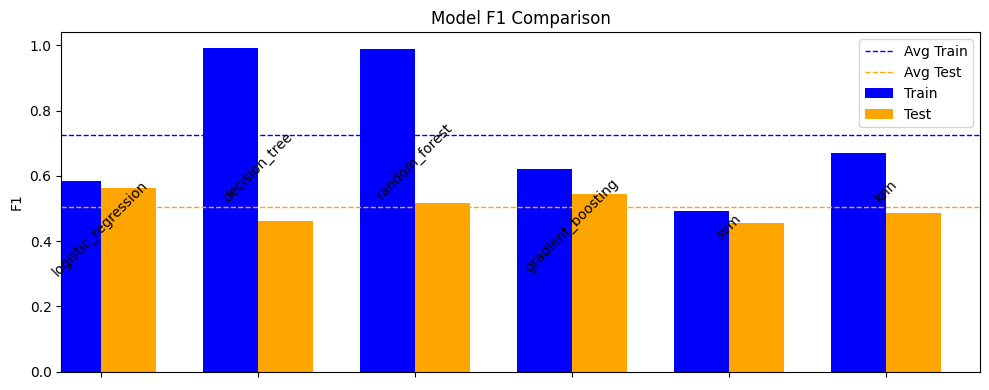

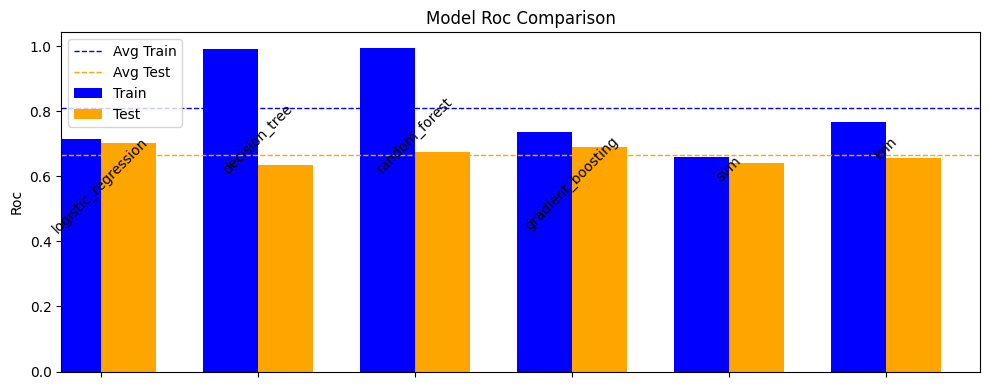

In [16]:
# Convert the result_dict to a DataFrame for easier plotting
metrics = ["accuracy", "precision", "recall", "f1", "roc"]
models = list(result_dict.keys())
data_train = {
    metric: {model: result_dict[model]["train"][metric] for model in models}
    for metric in metrics
}
data_test = {
    metric: {model: result_dict[model]["test"][metric] for model in models}
    for metric in metrics
}

df_train = pd.DataFrame(data_train)
df_test = pd.DataFrame(data_test)

# Plot the bar chart for each metric
for metric in metrics:
    fig, ax = plt.subplots(figsize=(10, 4))
    width = 0.35  # the width of the bars

    df_train[metric].plot(
        kind="bar", ax=ax, width=width, position=1, label="Train", color="blue"
    )
    df_test[metric].plot(
        kind="bar", ax=ax, width=width, position=0, label="Test", color="orange"
    )

    # Add horizontal lines for average performance
    avg_train = df_train[metric].mean()
    avg_test = df_test[metric].mean()
    ax.axhline(avg_train, color="blue", linestyle="--", linewidth=1, label="Avg Train")
    ax.axhline(avg_test, color="orange", linestyle="--", linewidth=1, label="Avg Test")

    # Adjust the layout
    ax.set_ylabel(metric.capitalize())
    ax.set_title(f"Model {metric.capitalize()} Comparison")
    ax.legend()

    # Set the x-tick labels inside the bars and rotate by 90 degrees
    ax.set_xticks(range(len(df_train.index)))
    ax.set_xticklabels([])

    # Draw the x-tick labels inside the bars rotated by 90 degrees
    for i, label in enumerate(df_train.index):
        bar_center = (df_train.loc[label, metric] + df_test.loc[label, metric]) / 2
        ax.text(i, bar_center, label, ha="center", va="center_baseline", rotation=45)

    plt.tight_layout()
    plt.show()


In [17]:
# Create a DataFrame combining df_train and df_test
df_combined = pd.concat(
    [df_train.add_suffix("_train"), df_test.add_suffix("_test")], axis=1
)

# Calculate the difference between train and test values
df_combined["accuracy_diff"] = (
    df_combined["accuracy_train"] - df_combined["accuracy_test"]
)
df_combined["precision_diff"] = (
    df_combined["precision_train"] - df_combined["precision_test"]
)
df_combined["recall_diff"] = df_combined["recall_train"] - df_combined["recall_test"]
df_combined["f1_diff"] = df_combined["f1_train"] - df_combined["f1_test"]
df_combined["roc_diff"] = df_combined["roc_train"] - df_combined["roc_test"]

# Detect models with overfitting (significant difference between train and test)
overfitting_threshold = 0.1  # Threshold to consider overfitting
overfitting_models = df_combined[
    (df_combined["accuracy_diff"] > overfitting_threshold)
    | (df_combined["precision_diff"] > overfitting_threshold)
    | (df_combined["recall_diff"] > overfitting_threshold)
    | (df_combined["f1_diff"] > overfitting_threshold)
    | (df_combined["roc_diff"] > overfitting_threshold)
]

# Calculate the average performance in train and test for each metric
mean_performance_train = df_combined[
    ["accuracy_train", "precision_train", "recall_train", "f1_train", "roc_train"]
].mean()
mean_performance_test = df_combined[
    ["accuracy_test", "precision_test", "recall_test", "f1_test", "roc_test"]
].mean()

# Detect models with low performance
# (performance in both train and test below the average of other models)
low_performance_models = df_combined[
    (df_combined["accuracy_train"] < mean_performance_train["accuracy_train"])
    & (df_combined["accuracy_test"] < mean_performance_test["accuracy_test"])
    & (df_combined["precision_train"] < mean_performance_train["precision_train"])
    & (df_combined["precision_test"] < mean_performance_test["precision_test"])
    & (df_combined["recall_train"] < mean_performance_train["recall_train"])
    & (df_combined["recall_test"] < mean_performance_test["recall_test"])
    & (df_combined["f1_train"] < mean_performance_train["f1_train"])
    & (df_combined["f1_test"] < mean_performance_test["f1_test"])
    & (df_combined["roc_train"] < mean_performance_train["roc_train"])
    & (df_combined["roc_test"] < mean_performance_test["roc_test"])
]

print(f"Models with overfitting: {list(overfitting_models.index)} ")
print(f"Models with low performance: {list(low_performance_models.index)} ")


Models with overfitting: ['decision_tree', 'random_forest', 'knn'] 
Models with low performance: ['knn'] 


In [18]:
# Detect models with similar performance in train and test
similar_performance_threshold = 0.05  # Threshold to consider similar performance
similar_performance_models = df_combined[
    (df_combined["accuracy_diff"].abs() < similar_performance_threshold)
    & (df_combined["precision_diff"].abs() < similar_performance_threshold)
    & (df_combined["recall_diff"].abs() < similar_performance_threshold)
    & (df_combined["f1_diff"].abs() < similar_performance_threshold)
    & (df_combined["roc_diff"].abs() < similar_performance_threshold)
]

print(
    f"Models with similar performance in train and test: {list(similar_performance_models.index)}"
)


Models with similar performance in train and test: ['logistic_regression', 'svm']


In [19]:
overfitting_models

,accuracy_train,precision_train,recall_train,f1_train,roc_train,accuracy_test,precision_test,recall_test,f1_test,roc_test,accuracy_diff,precision_diff,recall_diff,f1_diff,roc_diff
decision_tree,0.99,1.00,0.98,0.99,0.99,0.73,0.48,0.45,0.46,0.64,0.27,0.52,0.53,0.53,0.35
random_forest,0.99,0.99,0.99,0.99,0.99,0.78,0.59,0.46,0.52,0.67,0.22,0.40,0.53,0.47,0.32
knn,0.84,0.73,0.61,0.67,0.77,0.77,0.57,0.42,0.49,0.66,0.07,0.16,0.19,0.18,0.11


In [20]:
similar_performance_models


,accuracy_train,precision_train,recall_train,f1_train,roc_train,accuracy_test,precision_test,recall_test,f1_test,roc_test,accuracy_diff,precision_diff,recall_diff,f1_diff,roc_diff
logistic_regression,0.80,0.65,0.53,0.59,0.72,0.80,0.67,0.49,0.56,0.70,0.00,-0.02,0.04,0.02,0.01
svm,0.79,0.68,0.39,0.49,0.66,0.78,0.67,0.34,0.45,0.64,0.01,0.01,0.04,0.04,0.02


**Resultados de los Modelos:**

Modelos con overfitting:

- Árbol de Decisión

- Random Forest

- KNN

Modelos con bajo rendimiento:

- KNN

Modelos con desempeño estable en entrenamiento y prueba:

- Regresión Logística

- SVM

In [21]:
# Define the models to evaluate
models = {
    "logistic_regression": LogisticRegression(solver="liblinear", random_state=42),
    "decision_tree": DecisionTreeClassifier(random_state=42),
    "random_forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "gradient_boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "svm": SVC(probability=True, random_state=42),
}

# Evaluation metrics
scoring_metrics = ["accuracy", "f1", "precision", "recall"]

# KFold for the cross-validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)

# Variable to store the results of the cross-validation
cv_results = {metric: {} for metric in scoring_metrics}

# Cross-validation evaluation for each model and metric
for model_name, model in models.items():
    model_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])
    for metric in scoring_metrics:
        cv_results[metric][model_name] = cross_val_score(
            model_pipe, x_train, y_train, cv=kfold, scoring=metric
        )

# Convert results into a pandas DataFrame for each metric
cv_results_df = {metric: pd.DataFrame(cv_results[metric]) for metric in scoring_metrics}


In [22]:
# Create a DataFrame to store mean and std for each metric and model
mean_std_data = []

for metric_name in scoring_metrics:
    for model_name in models:
        mean_score = cv_results_df[metric_name][model_name].mean()
        std_score = cv_results_df[metric_name][model_name].std()
        mean_std_data.append({
            "Model": model_name,
            "Metric": metric_name,
            "Mean": mean_score,
            "Std": std_score,
        })

mean_std_df = pd.DataFrame(mean_std_data)
mean_std_df

,Model,Metric,Mean,Std
0,logistic_regression,accuracy,0.80,0.02
1,decision_tree,accuracy,0.73,0.02
2,random_forest,accuracy,0.77,0.02
3,gradient_boosting,accuracy,0.80,0.01
4,svm,accuracy,0.80,0.02
5,logistic_regression,f1,0.58,0.05
6,decision_tree,f1,0.49,0.04
7,random_forest,f1,0.51,0.05
8,gradient_boosting,f1,0.57,0.04
9,svm,f1,0.50,0.06


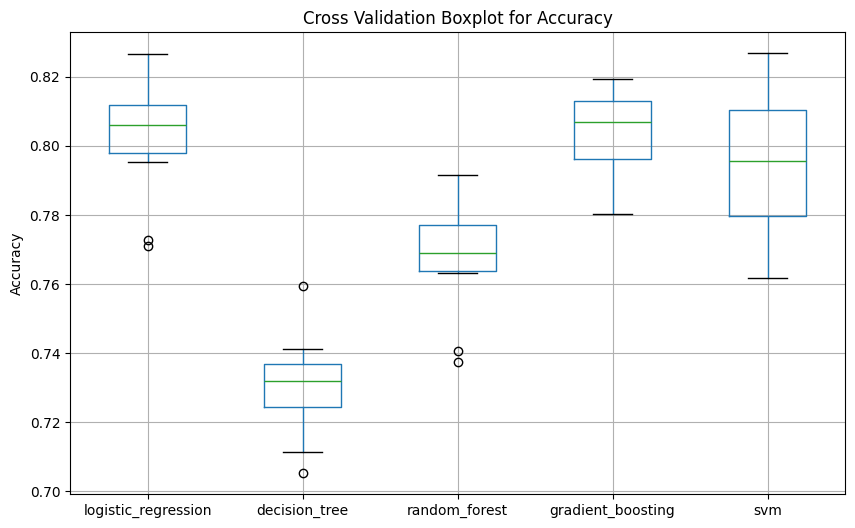

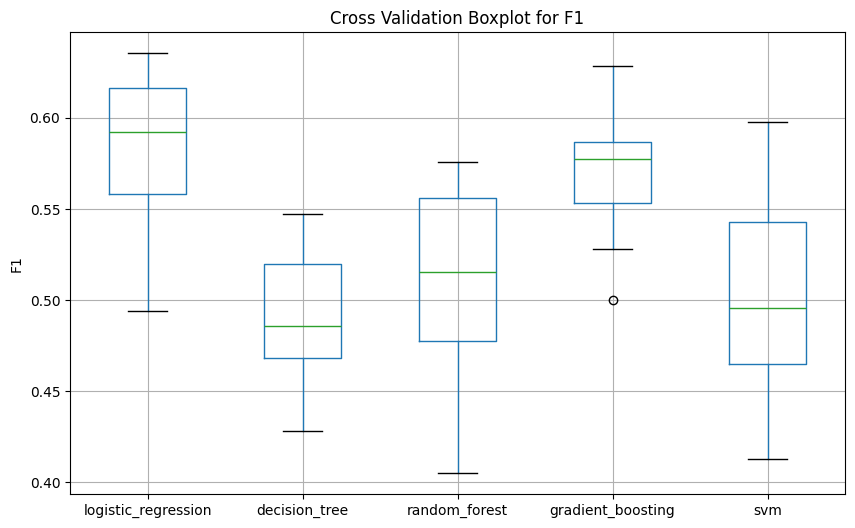

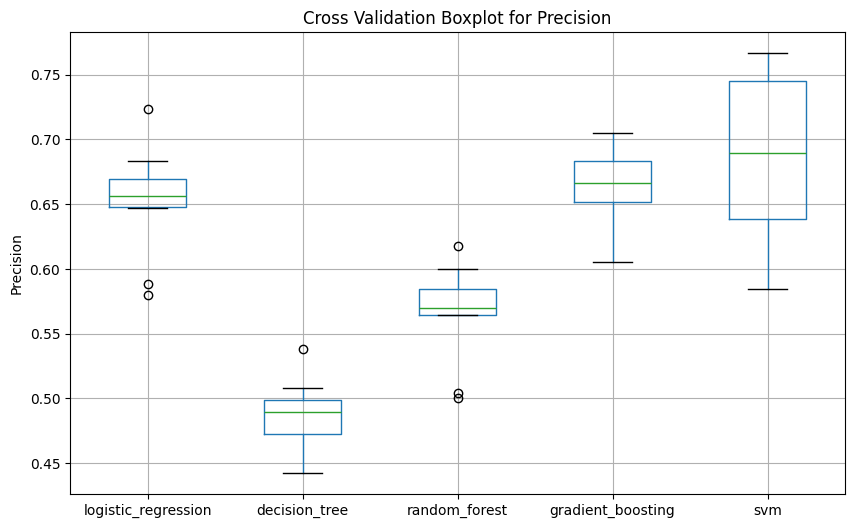

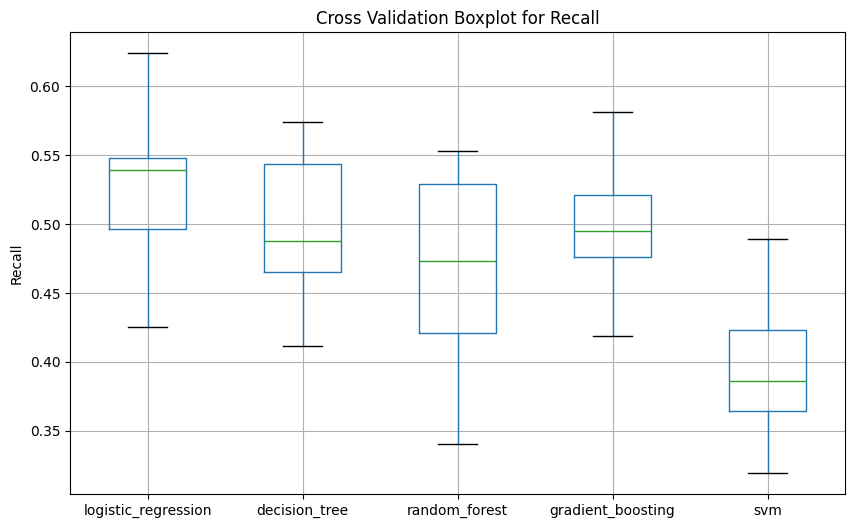

In [23]:
# Create a boxplot for the cross-validation results of each metric
for metric_name in scoring_metrics:
    plt.figure(figsize=(10, 6))
    cv_results_df[metric_name].boxplot()
    plt.title(f"Cross Validation Boxplot for {metric_name.capitalize()}")
    plt.ylabel(f"{metric_name.capitalize()}")
    plt.show()


Si solo se pudiera elegir una medida sería **recall**

Porqué es una medida sensible a los falsos negativos, que sería el error que no podemos tolerar dentro de este dataset, si queremos retener la mayor cantidad de clientes una predicción que dictaba que un cliente iba a permancer y no lo hizo en realidad sería el peor de los casos.

Descartar Modelos:

- KNN (bajo rendimiento).

- Árbol de Decisión y Random Forest (overfitting).

Priorizar Modelos para Optimización de Recall:

- Gradient Boosting (potencialmente bueno si se ajustan hiperparámetros).

- Regresión Logística (estable y se puede ajustar el umbral de clasificación).

- SVM (pero solo si no penaliza demasiado el Recall).



**Statistical Model Comparison**

In [24]:
result_df = cv_results_df["recall"]
result_df

,logistic_regression,decision_tree,random_forest,gradient_boosting,svm
0,0.43,0.41,0.34,0.42,0.34
1,0.48,0.46,0.45,0.48,0.36
2,0.49,0.48,0.41,0.47,0.32
3,0.58,0.55,0.54,0.58,0.47
4,0.52,0.47,0.51,0.48,0.43
5,0.62,0.57,0.55,0.58,0.49
6,0.55,0.51,0.49,0.52,0.39
7,0.54,0.56,0.54,0.51,0.37
8,0.54,0.49,0.45,0.52,0.39
9,0.54,0.46,0.41,0.48,0.41


In [25]:
from scipy.stats import f_oneway

model1 = result_df["logistic_regression"]
model2 = result_df["decision_tree"]
model3 = result_df["random_forest"]
model4 = result_df["gradient_boosting"]
model5 = result_df["svm"]

statistic, p_value = f_oneway(model1, model2, model3, model4)

print(f"Statistic: {statistic}")
print(f"p_value: {p_value}")

alpha = 0.05  # significance level

if p_value < alpha:
    print(
        "There is a statistically significant difference "
        "in the cross-validation results of the models."
    )
else:
    print(
        "There is no statistically significant difference "
        "in the cross-validation results of the models."
    )


Statistic: 1.7930964345799416
p_value: 0.16592959566632412
There is no statistically significant difference in the cross-validation results of the models.


Esto indica que al comparar los resultados de validación cruzada entre modelos, las diferencias entre sus métricas no son debidas al azar. Se ha aplicado algún test estadístico (por ejemplo, ANOVA o t-test pareado) para demostrar que al menos un modelo tiene un rendimiento significativamente diferente de los otros.

**Hyperparameter tunning**

Logistic Regression

In [26]:
score = "recall"

# Diccionario de parámetros corregido
parameters = [
    {
        "model__penalty": ["l1"],
        "model__C": [0.01, 0.1, 0.5, 1, 5, 10],
        "model__solver": ["liblinear"],
    },
    {
        "model__penalty": ["l2"],
        "model__C": [0.01, 0.1, 0.5, 1, 5, 10],
        "model__solver": ["lbfgs", "saga"],
    },
    {
        "model__penalty": ["elasticnet"],
        "model__C": [0.01, 0.1, 0.5, 1, 5, 10],
        "model__solver": ["saga"],
        "model__l1_ratio": [0.1, 0.5, 0.9],
    },
]

modelo = LogisticRegression(max_iter=5000)
logistic_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", modelo)])

grid_search = GridSearchCV(
    logistic_pipe,
    parameters,
    cv=StratifiedKFold(n_splits=5),
    scoring=score,
    n_jobs=-1,
    return_train_score=True,
)
# grid_search.fit(x_train, y_train)


In [27]:
# grid_search.best_params_

In [28]:
model = LogisticRegression(solver="liblinear", C=10, penalty="l1")
logistic_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

logistic_model = logistic_pipe.fit(x_train, y_train)

In [29]:
y_pred = logistic_model.predict(x_test)

summarize_classification(y_test, y_pred)

{'accuracy': 0.7913561847988078,
 'precision': 0.6323529411764706,
 'recall': 0.48863636363636365,
 'f1': 0.5512820512820513,
 'roc': np.float64(0.6938131313131314)}

Gradient Boosting

In [30]:
from sklearn.ensemble import GradientBoostingClassifier

parameters = {
    "model__n_estimators": [50, 100, 200],
    "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "model__max_depth": [3, 5, 7],
    "model__min_samples_split": [2, 5, 10],
}

modelo = GradientBoostingClassifier()
gb_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", modelo)])

grid_search = GridSearchCV(
    gb_pipe,
    parameters,
    cv=StratifiedKFold(n_splits=5),
    scoring=score,
    n_jobs=-1,
    return_train_score=True,
)
# grid_search.fit(x_train, y_train)


In [31]:
# grid_search.best_params_

In [32]:
# Definir modelo con los mejores hiperparámetros
model = GradientBoostingClassifier(
    learning_rate=0.2, max_depth=5, min_samples_split=2, n_estimators=50
)

# Crear pipeline
gb_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

# Entrenar modelo
gb_model = gb_pipe.fit(x_train, y_train)

# Hacer predicciones
y_pred = gb_model.predict(x_test)

# Evaluar modelo
summarize_classification(y_test, y_pred)


{'accuracy': 0.7697466467958272,
 'precision': 0.5793357933579336,
 'recall': 0.4460227272727273,
 'f1': 0.5040128410914928,
 'roc': np.float64(0.6654356060606061)}

SVM

In [33]:
parameters = {
    "model__kernel": ["linear", "rbf"],
    "model__C": [0.1, 1, 10, 50],
    "model__gamma": ["scale", "auto", 0.01, 0.1],
    "model__class_weight": ["balanced"],
}

modelo = SVC(probability=True)
svm_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", modelo)])

grid_search = GridSearchCV(
    svm_pipe,
    parameters,
    cv=StratifiedKFold(n_splits=5),
    scoring=score,
    n_jobs=-1,
    return_train_score=True,
)
# grid_search.fit(x_train, y_train)


In [34]:
# grid_search.best_params_

In [35]:
# Definir modelo con los mejores hiperparámetros
model = SVC(
    C=0.1,
    class_weight="balanced",
    gamma="scale",
    kernel="linear",
    probability=True,  # Permite obtener probabilidades para futuras métricas
)

# Crear pipeline
svm_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

# Entrenar modelo
svm_model = svm_pipe.fit(x_train, y_train)

# Hacer predicciones
y_pred = svm_model.predict(x_test)

# Evaluar modelo
summarize_classification(y_test, y_pred)


{'accuracy': 0.7093889716840537,
 'precision': 0.4694533762057878,
 'recall': 0.8295454545454546,
 'f1': 0.5995893223819302,
 'roc': np.float64(0.7481060606060608)}

**Final Evaluation Test**

In [36]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
)

In [37]:
# Logistic Regression
y_pred = logistic_model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86       990
           1       0.63      0.49      0.55       352

    accuracy                           0.79      1342
   macro avg       0.73      0.69      0.71      1342
weighted avg       0.78      0.79      0.78      1342



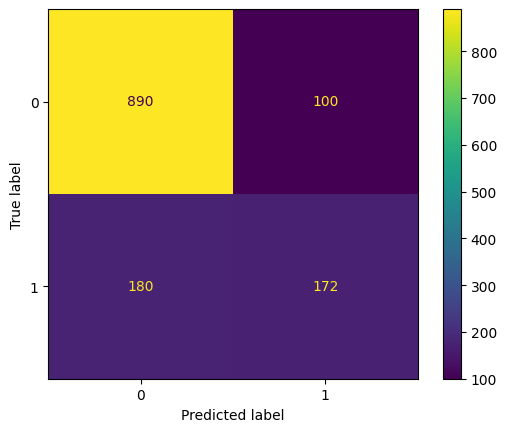

In [38]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

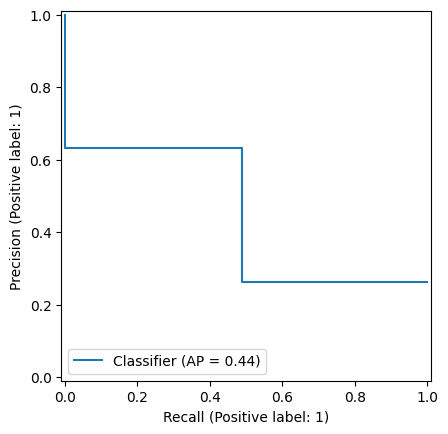

In [39]:
PrecisionRecallDisplay.from_predictions(y_test, y_pred)


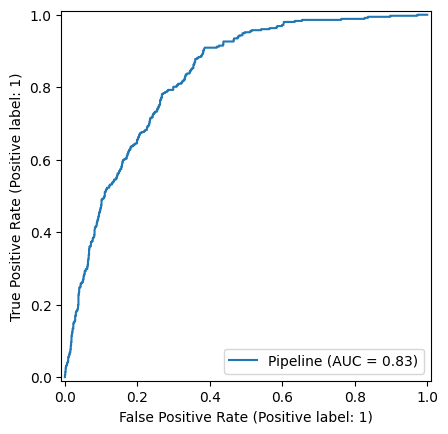

In [40]:
log_plot = RocCurveDisplay.from_estimator(logistic_model, x_test, y_test)
plt.show()


In [41]:
# Gradient Boosting
y_pred = gb_model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       990
           1       0.58      0.45      0.50       352

    accuracy                           0.77      1342
   macro avg       0.70      0.67      0.68      1342
weighted avg       0.76      0.77      0.76      1342



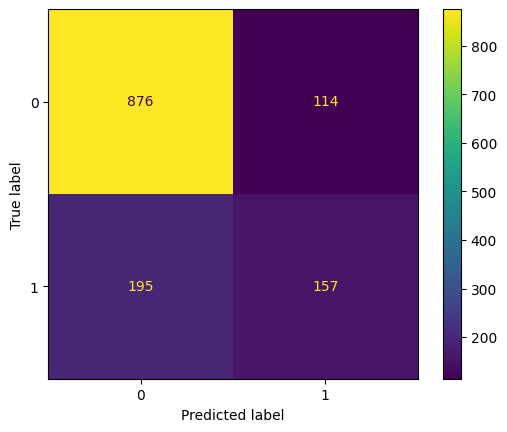

In [42]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)


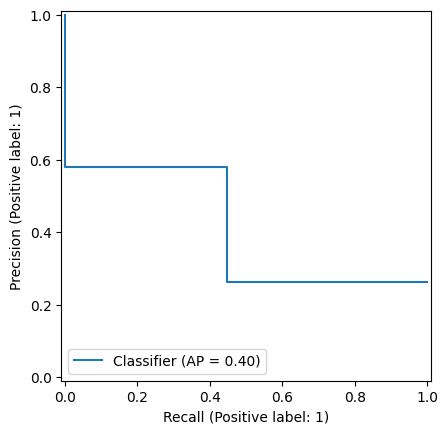

In [43]:
PrecisionRecallDisplay.from_predictions(y_test, y_pred)


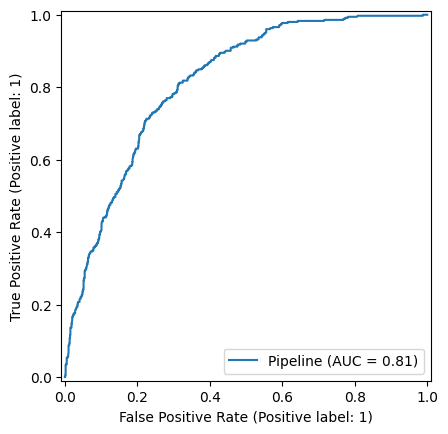

In [44]:
gb_plot = RocCurveDisplay.from_estimator(gb_model, x_test, y_test)
plt.show()


In [45]:
# SVM
y_pred = svm_model.predict(x_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.92      0.67      0.77       990
           1       0.47      0.83      0.60       352

    accuracy                           0.71      1342
   macro avg       0.69      0.75      0.69      1342
weighted avg       0.80      0.71      0.73      1342



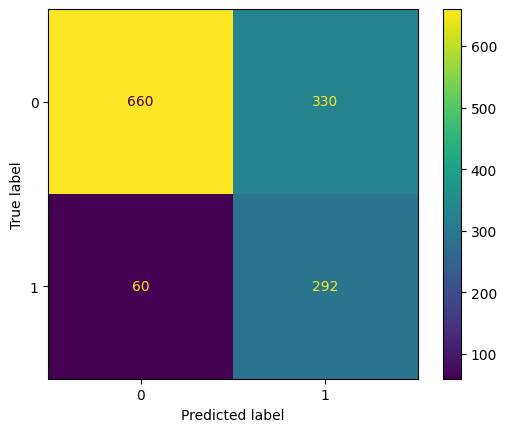

In [46]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

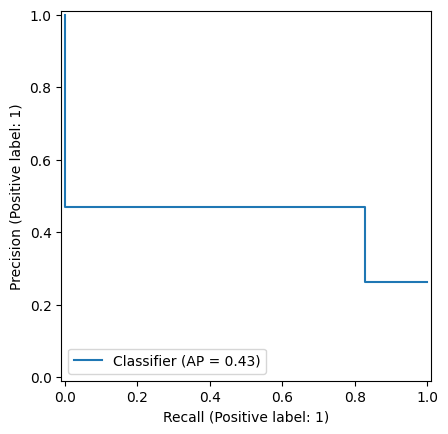

In [47]:
PrecisionRecallDisplay.from_predictions(y_test, y_pred)


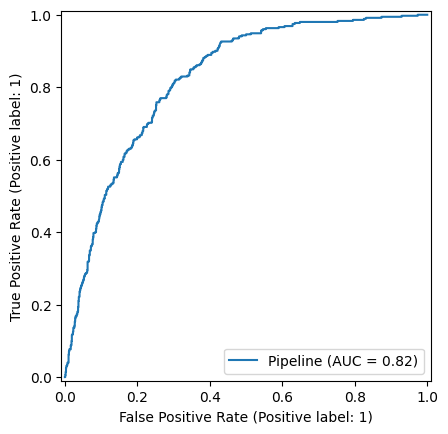

In [48]:
svm_plot = RocCurveDisplay.from_estimator(svm_model, x_test, y_test)
plt.show()

**Model comparison**

En comparación con los desempeños de los otros modelos, el SVM tiene un desempeño sobresaliente en el Recall, por ende este va a ser nuestro modelo.

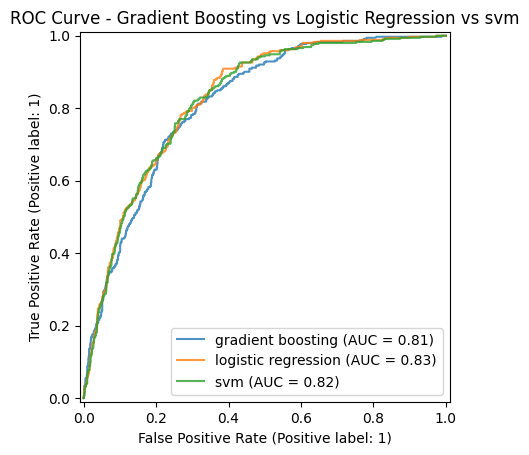

In [49]:
ax = plt.gca()
gb_plot.plot(ax=ax, alpha=0.8, name="gradient boosting")
log_plot.plot(ax=ax, alpha=0.8, name="logistic regression")
svm_plot.plot(ax=ax, alpha=0.8, name="svm")
plt.title("ROC Curve - Gradient Boosting vs Logistic Regression vs svm")
plt.show()


**SVM Learning Curve**

Esta curva es utilizada para saber si el modelo tiene overfitting o underfitting

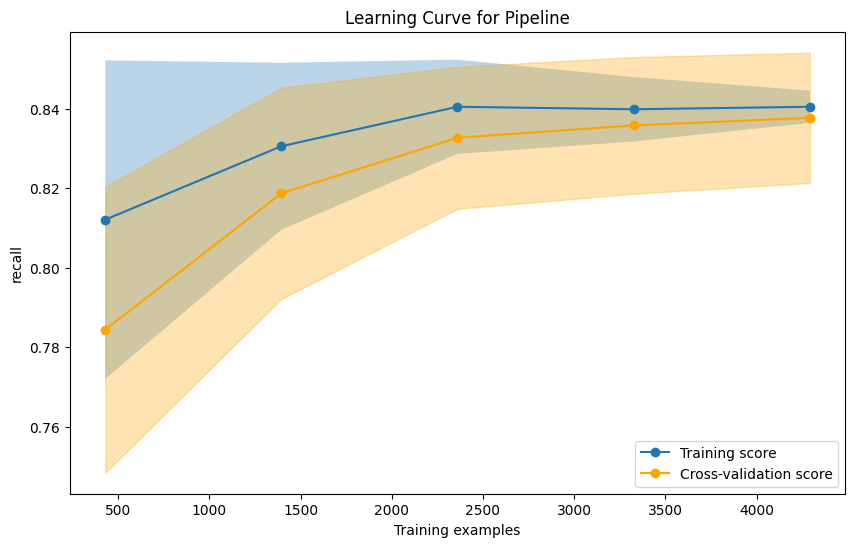

Training Sizes: [ 429 1394 2360 3326 4292]
Training Scores Mean: [0.81212298 0.83060129 0.84054922 0.8399213  0.84055111]
Training Scores Std: [0.04010706 0.02103611 0.01186872 0.00810922 0.00405725]
Test Scores Mean: [0.78440483 0.81874789 0.83273739 0.83586091 0.83776996]
Test Scores Std: [0.03600178 0.02658861 0.01787085 0.01719625 0.0163882 ]


In [50]:
model = svm_model

# Parameters for the learning curve
common_params = {
    "X": x_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=123),
    "n_jobs": -1,
    "return_times": True,
}

scoring_metric = "recall"

# Obtain the learning curve values including fit and score times
train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
    model, **common_params, scoring=scoring_metric
)

# Calculate the mean and standard deviation of the scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Calculate the mean and standard deviation of the fit and score times
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)
score_times_mean = np.mean(score_times, axis=1)
score_times_std = np.std(score_times, axis=1)

# Plot the learning curve
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)
ax.plot(train_sizes, train_mean, "o-", label="Training score")
ax.plot(train_sizes, test_mean, "o-", color="orange", label="Cross-validation score")
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.3)
ax.fill_between(
    train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.3, color="orange"
)

# Configure the title and labels
ax.set_title(f"Learning Curve for {model.__class__.__name__}")
ax.set_xlabel("Training examples")
ax.set_ylabel(scoring_metric)
ax.legend(loc="best")

# Show the plot
plt.show()

# Print the values for analysis
print("Training Sizes:", train_sizes)
print("Training Scores Mean:", train_mean)
print("Training Scores Std:", train_std)
print("Test Scores Mean:", test_mean)
print("Test Scores Std:", test_std)


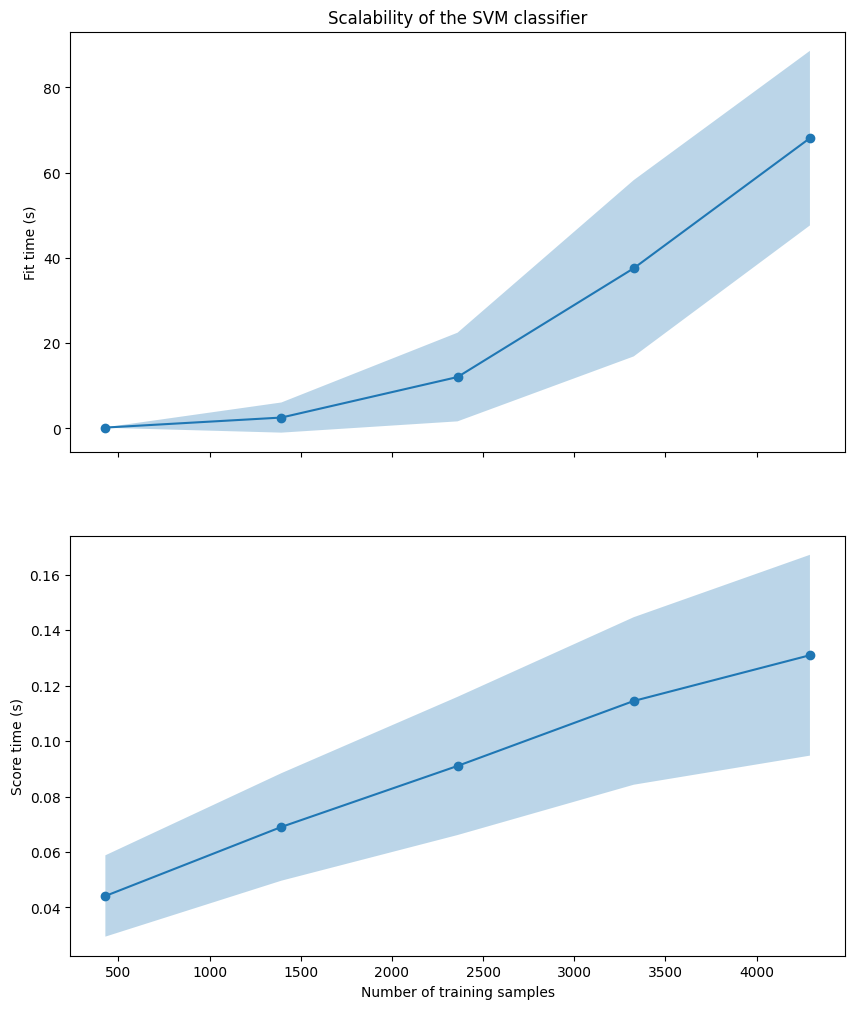

Fit Times Mean: [ 0.19954221  2.54955335 12.05868032 37.57801478 68.11093367]
Fit Times Std: [ 0.05211647  3.53746357 10.40148547 20.68280773 20.48554706]
Score Times Mean: [0.0441533  0.06905783 0.09107135 0.11451063 0.13101128]
Score Times Std: [0.01466967 0.0193935  0.0249356  0.03022153 0.03622719]


In [51]:
# Plot the scalability regarding fit time and score time
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 12), sharex=True)

# Scalability regarding the fit time
ax[0].plot(train_sizes, fit_times_mean, "o-")
ax[0].fill_between(
    train_sizes,
    fit_times_mean - fit_times_std,
    fit_times_mean + fit_times_std,
    alpha=0.3,
)
ax[0].set_ylabel("Fit time (s)")
ax[0].set_title("Scalability of the SVM classifier")

# Scalability regarding the score time
ax[1].plot(train_sizes, score_times_mean, "o-")
ax[1].fill_between(
    train_sizes,
    score_times_mean - score_times_std,
    score_times_mean + score_times_std,
    alpha=0.3,
)
ax[1].set_ylabel("Score time (s)")
ax[1].set_xlabel("Number of training samples")

# Show the plot
plt.show()

# Print the fit and score times for analysis
print("Fit Times Mean:", fit_times_mean)
print("Fit Times Std:", fit_times_std)
print("Score Times Mean:", score_times_mean)
print("Score Times Std:", score_times_std)

**Save the model**

In [ ]:
from joblib import dump

# Definir rutas
BASE_DIR = Path("/home/lof/Projects/Telco-Customer-Churn")
MODELS_DIR = BASE_DIR / "models"

# Crear la carpeta "models" si no existe
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Ruta para guardar el modelo
model_path = MODELS_DIR / "Churn_classification-SVM-v1.joblib"

# Guardar el modelo entrenado
dump(svm_model, model_path)

print(f"Modelo guardado en: {model_path}")


Modelo guardado en: /home/lof/Projects/Telco-Customer-Churn/models/Churn_classification-SVM-v1.joblib


In [57]:
from joblib import load

my_model = load("Churn_classification-SVM-v1.joblib")


In [58]:
# test data

x_test.head()

,PhoneService,MultipleLines,InternetService,Contract,SeniorCitizen,PaymentMethod,tenure,MonthlyCharges
10045,1.00,No,DSL,Two year,0.00,Credit card (automatic),69.00,61.45
10159,1.00,Yes,No,Month-to-month,0.00,Bank transfer (automatic),5.00,25.90
1662,1.00,No,Fiber optic,Month-to-month,0.00,Mailed check,1.00,70.65
262,0.00,No phone service,DSL,Two year,0.00,Credit card (automatic),67.00,54.20
4902,0.00,No phone service,DSL,Two year,0.00,Bank transfer (automatic),38.00,60.00


In [59]:
# check predictions
my_model.predict(x_test.head())

array([0, 0, 1, 0, 0])